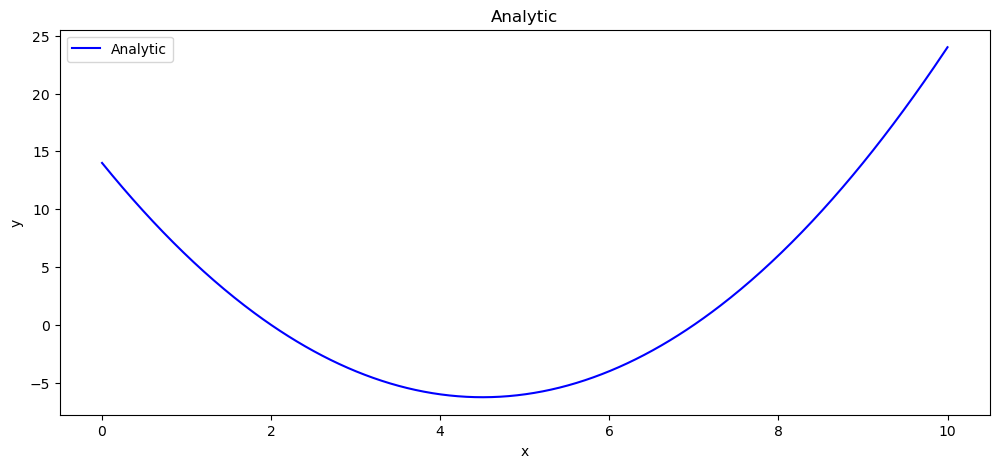

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)

f_true = lambda x: x**2 - 9*x + 14

sigma = 2

X_test = np.linspace(0,10,500)

Y_true = np.array([f_true(xt) for xt in X_test])


# Plotting
plt.figure(figsize=(12, 5))
plt.plot(X_test, Y_true, label="Analytic", color="blue")


plt.title(f"Analytic")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# fig_name = f"c1_pce_{n}p{degree}d"
# plt.savefig('figs/'+fig_name)
plt.show()


In [2]:
# data generation
X_train = np.arange(0,11,2)

n = len(X_train)
num_rep = 10
# X_train = X_train.repeat(num_rep)
Y_train = f_true(X_train) + sigma * np.random.normal(loc=0, scale=sigma, size=n)  # Training outputs
# Y_train = f_true(X_train) + sigma * np.random.normal(loc=0, scale=sigma, size=n*num_rep)  # Training outputs

In [3]:
import GPy

# Define the kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

# Create the GP model
gp_model_gpy = GPy.models.GPRegression(X_train.reshape(-1,1), Y_train.reshape(-1,1), kernel)

# Optimize the model (find the best hyperparameters)
gp_model_gpy.optimize(messages=True)

# Print the optimized model's parameter values
print(gp_model_gpy)



Name : GP regression
Objective : 23.401308311441777
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      165.84987171537182  |      +ve      |        
  rbf.lengthscale          |      1.4437309266431746  |      +ve      |        
  Gaussian_noise.variance  |  0.00028635082231300447  |      +ve      |        


In [4]:
gp_model_gpy.predict(np.array([5]).reshape(-1,1))

(array([[-9.4993]]), array([[11.8591]]))

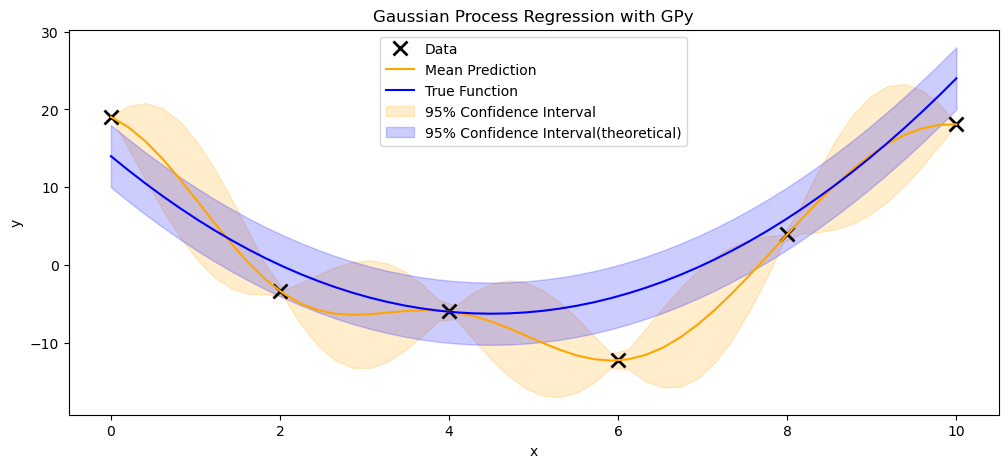

In [5]:
# Predict at new data points
X_new = np.linspace(0, 10, 50).reshape(-1, 1)  # Test inputs
Y_pred, Y_var = gp_model_gpy.predict(X_new)  # Predictive mean and variance
Y_true = np.array([f_true(xn) for xn in X_new])

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(X_train, Y_train, 'kx', markersize=10, markeredgewidth=2, label="Data")

plt.plot(X_new, Y_pred, label='Mean Prediction', color='orange')
plt.plot(X_new, Y_true, label="True Function", color="blue")
plt.fill_between(X_new.flatten(), (Y_pred - 2*np.sqrt(Y_var)).flatten(), (Y_pred + 2*np.sqrt(Y_var)).flatten(), color='orange',
                 alpha=0.2, label='95% Confidence Interval')
plt.fill_between(X_new.flatten(), (Y_true - 2*sigma).flatten(), (Y_true + 2*sigma).flatten(), color='blue',
                 alpha=0.2, label='95% Confidence Interval(theoretical)')
plt.title(f"Gaussian Process Regression with GPy")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [6]:
print(list(zip(X_train, Y_train)))

[(0, 19.04323925482466), (2, -3.3441658958696645), (4, -5.952736061002801), (6, -12.254027860172586), (8, 3.9440528150365326), (10, 18.08881138528539)]


In [7]:
def rbf_kernel(X1, X2, sigma_f=1., length_scale=1.):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

sigma_noise = 1
K = rbf_kernel(X_train.reshape(-1,1), X_train.reshape(-1,1), sigma_f=1, length_scale=1) + sigma_noise**2 * np.eye(len(X_train))
print(K)

[[2.0000e+00 1.3534e-01 3.3546e-04 1.5230e-08 1.2664e-14 1.9287e-22]
 [1.3534e-01 2.0000e+00 1.3534e-01 3.3546e-04 1.5230e-08 1.2664e-14]
 [3.3546e-04 1.3534e-01 2.0000e+00 1.3534e-01 3.3546e-04 1.5230e-08]
 [1.5230e-08 3.3546e-04 1.3534e-01 2.0000e+00 1.3534e-01 3.3546e-04]
 [1.2664e-14 1.5230e-08 3.3546e-04 1.3534e-01 2.0000e+00 1.3534e-01]
 [1.9287e-22 1.2664e-14 1.5230e-08 3.3546e-04 1.3534e-01 2.0000e+00]]


In [8]:
L = np.linalg.cholesky(K)
print(L)

[[1.4142e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [9.5696e-02 1.4110e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.3721e-04 9.5900e-02 1.4110e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.0769e-08 2.3775e-04 9.5901e-02 1.4110e+00 0.0000e+00 0.0000e+00]
 [8.9549e-15 1.0794e-08 2.3775e-04 9.5901e-02 1.4110e+00 0.0000e+00]
 [1.3638e-22 8.9755e-15 1.0794e-08 2.3775e-04 9.5901e-02 1.4110e+00]]


In [9]:
z = np.linalg.solve(L, Y_train)
w = np.linalg.solve(L.T, z)
print(w)

[ 9.6683 -2.1615 -2.4203 -6.0848  1.7802  8.925 ]


In [10]:
# Let's predict a trained point x=2
xt1 = 5
k1= rbf_kernel(X_train.reshape(-1, 1), np.array([xt1]).reshape(-1, 1))
y_pred1 = np.dot(k1.T, w)
print(k1)

[[3.7267e-06]
 [1.1109e-02]
 [6.0653e-01]
 [6.0653e-01]
 [1.1109e-02]
 [3.7267e-06]]


In [11]:
print(w), print(y_pred1), print(f_true(xt1))

[ 9.6683 -2.1615 -2.4203 -6.0848  1.7802  8.925 ]
[-5.1628]
-6


(None, None, None)